In [1]:
# DIRECTORY SET
import os
import sys
from pathlib import Path
base_dir=Path(os.getcwd()).parent.parent
os.chdir(base_dir)
print(os.getcwd())

# ENVIRONMENT VARIABLES
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


In [2]:
%load_ext autoreload
%autoreload 2

from destinyapp.models import StreamRecapData

from destinyapp.customlibrary import services
from destinyapp.customlibrary import utils

In [3]:
# Specific imports
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from bs4 import BeautifulSoup
from collections import defaultdict
import textwrap
import json

In [4]:
video_id="3kJr7ODrwNw"

video_id="3CkGjIxIZlI"

video_id="LJxBnSyH0T4"

video_id="75Btb7bWpqw" # 4.5 hr long destiny stream
# load the video data
stream_recap_data=await utils.get_recap_data(video_id)

In [5]:
test_text_chunks=await services.visualization.create_text_chunks(stream_recap_data.transcript, 0)

Number of chunks:  198


In [6]:
chunk_batches=await services.visualization.generate_text_chunk_batches(test_text_chunks)

In [160]:
topic_annotations_str=await services.visualization.annotate_major_minor_topics(stream_recap_data.recap)

Cost:  0.007608


In [161]:
print(topic_annotations_str)

Major Topics:
Category: 'Supreme Court Decision on Chevron Deference' | Context: The Supreme Court overturned the Chevron deference doctrine, shifting power from executive agencies to the judiciary and allowing courts to substitute judgment for scientific experts.

Category: 'EPA Authorization and Regulations' | Context: A Congressional hearing with EPA Administrator Michael Regan discussed the EPA's formal authorization by Congress and the impact of EPA regulations on energy costs.

Category: 'Iran Hostage Crisis (1979-1981)' | Context: A detailed account of the events leading to and during the Iran Hostage Crisis, including the Iranian Revolution, takeover of the US Embassy in Tehran, and its impact on US-Iran relations and Carter's presidency.

Category: 'Economic Discussions' | Context: Discussions on supply and demand principles, housing market, student loan debt forgiveness, interest rates, inflation, and government interventions in markets.

Minor Topics:
- 'Luxury beliefs and c

In [164]:
# topic_annotations_str=topic_annotations_str2
temp_annotation_list=topic_annotations_str.split("Category: ")
major_topics=[]
for temp_annotation in temp_annotation_list:
    if " | Context:" in temp_annotation:
        major_topic=temp_annotation.split(" | Context:")[0].strip()
        # get rid of ' if it starts and ends with that
        if major_topic[0]=="'" and major_topic[-1]=="'":
            major_topic=major_topic[1:-1]

        major_topics.append(major_topic)

minor_topics=[]
if "Minor Topics:" in topic_annotations_str:
    temp_minor_topics=topic_annotations_str.split("Minor Topics:\n")[-1].split("\n- ")
elif "Minor topics:" in topic_annotations_str:
    temp_minor_topics=topic_annotations_str.split("Minor topics:\n")[-1].split("\n- ")
for i in range(len(temp_minor_topics)):
    minor_topic=temp_minor_topics[i].strip()
    if minor_topic!="":
        minor_topics.append(minor_topic)

print(major_topics)
print(minor_topics)

['Supreme Court Decision on Chevron Deference', 'EPA Authorization and Regulations', 'Iran Hostage Crisis (1979-1981)', 'Economic Discussions']
["- 'Luxury beliefs and campus activism'", "'Ukraine-NATO membership prospects'", "'Military draft and concept of freedom'", "'Age-segregated internet access proposal'", "'Parenting and education in the digital age'", "'German casualties in World War II'", "'Life expectancy in ancient Rome'", "'1953 Iranian coup (Operation Ajax)'", "'Cold War dynamics'", "'Destiny's public relationships and content creation style'", "'Discussions on debate techniques and internet communication'", "'Research process and fact-checking during streams'", "'Interactions with viewers and other content creators'", "'Brain chemistry and drug effects'", "'Property easements'", "'Optimal age for pregnancy'", "'Charter schools and education alternatives'"]


In [183]:
responses, annotated_results=await services.visualization.annotate_all_batches(chunk_batches, topic_annotations_str)

Cost:  0.002128
Cost:  0.0021964999999999997
Cost:  0.00230075
Cost:  0.0024827499999999997
Cost:  0.0024275
Cost:  0.00251575
Cost:  0.00265025
Cost:  0.0029897500000000002
Cost:  0.0027185
Cost:  0.0027287500000000003
Results:  20
Results:  20
Results:  20
Results:  20
Results:  20
Results:  20
Results:  20
Results:  20
Results:  20
Results:  18


In [181]:
services.visualization.process_annotation_response(responses[4], chunk_batches[4])

Results:  7


[{'segment': 1,
  'category': 'Constitutional Provisions for Presidential Appointments',
  'annotation': 'The text discusses the appointment of officers by the President, as outlined in Article 2, Section 2, Clause 2 of the U.S. Constitution. It explains that the President can appoint officers whose appointments are not otherwise provided for in the Constitution, and that Congress can vest the appointment of inferior officers in the President, the courts, or the heads of departments.',
  'text': "se appointments are not here and otherwise provided for and which shall be established by law. I think it would be this part. Right. But the Congress may by law vest the appointment of such inferior officers as they think proper in the president alone, in the courts of law or in the heads department. Okay, so, article two, section two, clause two. The president of the United States shall have the power bind with the advisingent of the senate to appoint officers whose appointments are not here 

In [180]:
responses[4]

'Segment 1: The text discusses the appointment of officers by the President, as outlined in Article 2, Section 2, Clause 2 of the U.S. Constitution. It explains that the President can appoint officers whose appointments are not otherwise provided for in the Constitution, and that Congress can vest the appointment of inferior officers in the President, the courts, or the heads of departments. ||Constitutional Provisions for Presidential Appointments||\n\nSegment 2: The text discusses the EPA\'s lack of formal authorization by Congress and the Supreme Court\'s overturning of the Chevron deference doctrine, which had previously given the EPA more legal standing to enact regulations. The speaker argues that the EPA has overstepped its authority and that Congress should have more oversight over the agency. ||EPA Authorization and Regulations||\n\nSegment 3: The text further discusses the implications of the Supreme Court\'s Chevron decision, clarifying that it does not automatically invalid

In [184]:
annotated_results[21]

{'segment': 2,
 'category': 'Non Categorized',
 'annotation': 'The text segment discusses the political dynamics in Germany before World War II, including the rise of the communist and Nazi parties due to discontent with the status quo. It also touches on the difficulty in defending or justifying the status quo.',
 'text': " Germany is that it seems similar to that and that you have a liberal world order and because things are going okay for a bit, but there's some discontent. As the discontent grows, people look at the liberal world order. They don't understand any of the good they get from it. They just have, like, complaints about some of the bad things. And then this causes people to veer off on extreme sides on both ends. In Germany, it was the communist party that I think was the KPD, and then it was also the nazi party, which was the nazi socialist party. At times they worked together, at times they fought, but both of them agreed that they wanted to get rid of, basically the li

In [12]:
# save the annotated results to json
with open("anootation_results.json", "w") as f:
    json.dump(annotated_results, f)

In [13]:
# load the annotated results
anoootated_results=json.load(open("anootation_results.json", "r"))

In [142]:
test_text_chunks[21]

" Germany is that it seems similar to that and that you have a liberal world order and because things are going okay for a bit, but there's some discontent. As the discontent grows, people look at the liberal world order. They don't understand any of the good they get from it. They just have, like, complaints about some of the bad things. And then this causes people to veer off on extreme sides on both ends. In Germany, it was the communist party that I think was the KPD, and then it was also the nazi party, which was the nazi socialist party. At times they worked together, at times they fought, but both of them agreed that they wanted to get rid of, basically the liberals at the time. But I think that a lot of it stems from kind of like a discontent with the status quo, because for some reason we have a really hard time defending or justifying the status quo. I don't know why that is the case, but almost took place. And now I offer back. You mean like we actually did in this case is a

In [143]:
annotated_results[21]

{'segment': 2,
 'category': 'Economic Discussions',
 'annotation': 'The user discusses discontent with the status quo leading to extremism, drawing parallels to pre-WWII Germany.',
 'text': " Germany is that it seems similar to that and that you have a liberal world order and because things are going okay for a bit, but there's some discontent. As the discontent grows, people look at the liberal world order. They don't understand any of the good they get from it. They just have, like, complaints about some of the bad things. And then this causes people to veer off on extreme sides on both ends. In Germany, it was the communist party that I think was the KPD, and then it was also the nazi party, which was the nazi socialist party. At times they worked together, at times they fought, but both of them agreed that they wanted to get rid of, basically the liberals at the time. But I think that a lot of it stems from kind of like a discontent with the status quo, because for some reason we h

# Start of Plot 

In [188]:
soup = BeautifulSoup(stream_recap_data.linked_transcript, 'html.parser')
soup_list=soup.find_all('a')

transcript_soup_character_counter=[]
character_count_total=0
temp_time=0
for link in soup_list:
    link_text = link.get_text()
    character_count_total+=len(link_text)

    if link.get('href') is not None:
        temp_time=int(link['href'].split("t=")[-1].split("s")[0])

    transcript_soup_character_counter.append([character_count_total, temp_time])

def find_nearest_time_at_character_count(transcript_soup_character_counter, character_count):
    # middle sort the list to get to the closest character count quickly
    
    l=0
    r=len(transcript_soup_character_counter)-1

    while l<r:
        m=(l+r)//2
        if transcript_soup_character_counter[m][0]<character_count:
            l=m+1
        else:
            r=m

    if l==0:
        return transcript_soup_character_counter[l][1]
    else:
        if abs(transcript_soup_character_counter[l][0]-character_count)<abs(transcript_soup_character_counter[l-1][0]-character_count):
            return transcript_soup_character_counter[l][1]
        else:
            return transcript_soup_character_counter[l-1][1]


# Get the category segments
category_segments=[]
for i, annotated_segment in enumerate(annotated_results):
    category=annotated_segment["category"]
    content=annotated_segment["annotation"]
    category_segments.append(category)

# Fix min topic annotations
for i, color_segment in enumerate(category_segments):
    if color_segment not in major_topics:
        # print(f"Segment {i}: {color_segment}")
        if (color_segment.lower()=="non categorized") or (color_segment.lower()=="non-categorized"):
            category_segments[i]="non categorized"
        else:
            category_segments[i]="minor topics"


# Get the widths of the segments
category_and_width_segments=[]
for i, annotated_segment in enumerate(category_segments):

    end_time=find_nearest_time_at_character_count(transcript_soup_character_counter, (i+1)*1000)
    start_time=find_nearest_time_at_character_count(transcript_soup_character_counter, i*1000)
    width=end_time-start_time
    category_and_width_segments.append([annotated_segment, width, start_time, end_time])
    print(f"Segment {i}: {annotated_segment}, {width}")



# Create the segments
color_dict={
    "minor topics": "yellow",
    "non categorized": "black"
}
major_topic_color_list=[
    "green",
    "blue",
    "purple",
    "orange",
    "red",
    # keep going if needed
    "pink",
    "brown",
    "cyan",
    "gold",
    "gray",
    "lime",
    "magenta",
    "olive",
]
for i, mt in enumerate(major_topics):
    color_dict[mt]=major_topic_color_list[i]
segments=[]
for category, width, start, end in category_and_width_segments:
    segment={"category": category, "width": width, "color": color_dict[category], "start": start, "end": end}
    segments.append(segment)

# Normalize Widths
total_width=0
total_width_circle=0
for segment in segments:
    total_width+=segment["width"]
    if segment["category"]!="non categorized":
        total_width_circle+=segment["width"]

# Normalize circle widths
circle_mutlipler=total_width/total_width_circle
width_mutliplier=10/total_width
for segment in segments:
    segment["width"]=segment["width"]*width_mutliplier

# get average location of each segment category
category_locations={}
x_location=0
for i, segment in enumerate(segments):
    if segment["category"]!="non categorized":
        temp_locations=category_locations.get(segment["category"], [])
        temp_locations.append(segment["width"]/2+x_location)
        category_locations[segment["category"]]=temp_locations
    else:
        category_locations[segment["category"]]=10

    x_location+=segment["width"]

# for each segment, get the average location of the category
for category_location in category_locations:
    category_locations[category_location]=np.mean(category_locations[category_location])
category_locations=dict(sorted(category_locations.items(), key=lambda item: item[1]))

Segment 0: Supreme Court Decision on Chevron Deference, 148
Segment 1: Supreme Court Decision on Chevron Deference, 52
Segment 2: Supreme Court Decision on Chevron Deference, 54
Segment 3: EPA Authorization and Regulations, 57
Segment 4: EPA Authorization and Regulations, 60
Segment 5: EPA Authorization and Regulations, 56
Segment 6: EPA Authorization and Regulations, 88
Segment 7: non categorized, 62
Segment 8: non categorized, 81
Segment 9: non categorized, 96
Segment 10: non categorized, 87
Segment 11: Economic Discussions, 65
Segment 12: Economic Discussions, 82
Segment 13: Economic Discussions, 63
Segment 14: Economic Discussions, 70
Segment 15: non categorized, 59
Segment 16: non categorized, 39
Segment 17: non categorized, 56
Segment 18: non categorized, 72
Segment 19: non categorized, 76
Segment 20: non categorized, 54
Segment 21: non categorized, 64
Segment 22: non categorized, 137
Segment 23: non categorized, 93
Segment 24: non categorized, 82
Segment 25: non categorized, 77


In [191]:
# Convert the adjacent segments of the same category into one segment
temp_segments=[]
temp_start_time=segments[0]["start"]
prev_segment=segments[0]
temp_width=prev_segment["width"]
for segment in segments[1:]:
    if prev_segment["category"]!=segment["category"]:
        prev_segment["width"]=temp_width
        prev_segment["start"]=temp_start_time
        temp_segments.append(prev_segment)
        temp_start_time=segment["start"]
        temp_width=0
    temp_width+=segment["width"]
    prev_segment=segment
if prev_segment["category"]==segment["category"]:
    prev_segment["width"]=temp_width
    prev_segment["start"]=temp_start_time
    temp_segments.append(prev_segment)
segments=temp_segments

# PLOT FUNCTION

Total width: 9.999999999999998
Circle current x: 2.064582291841573
Circle current x: 3.658635275781935
Circle current x: 5.105542678799635
Circle current x: 6.711048309753015
Circle current x: 8.412712558872357


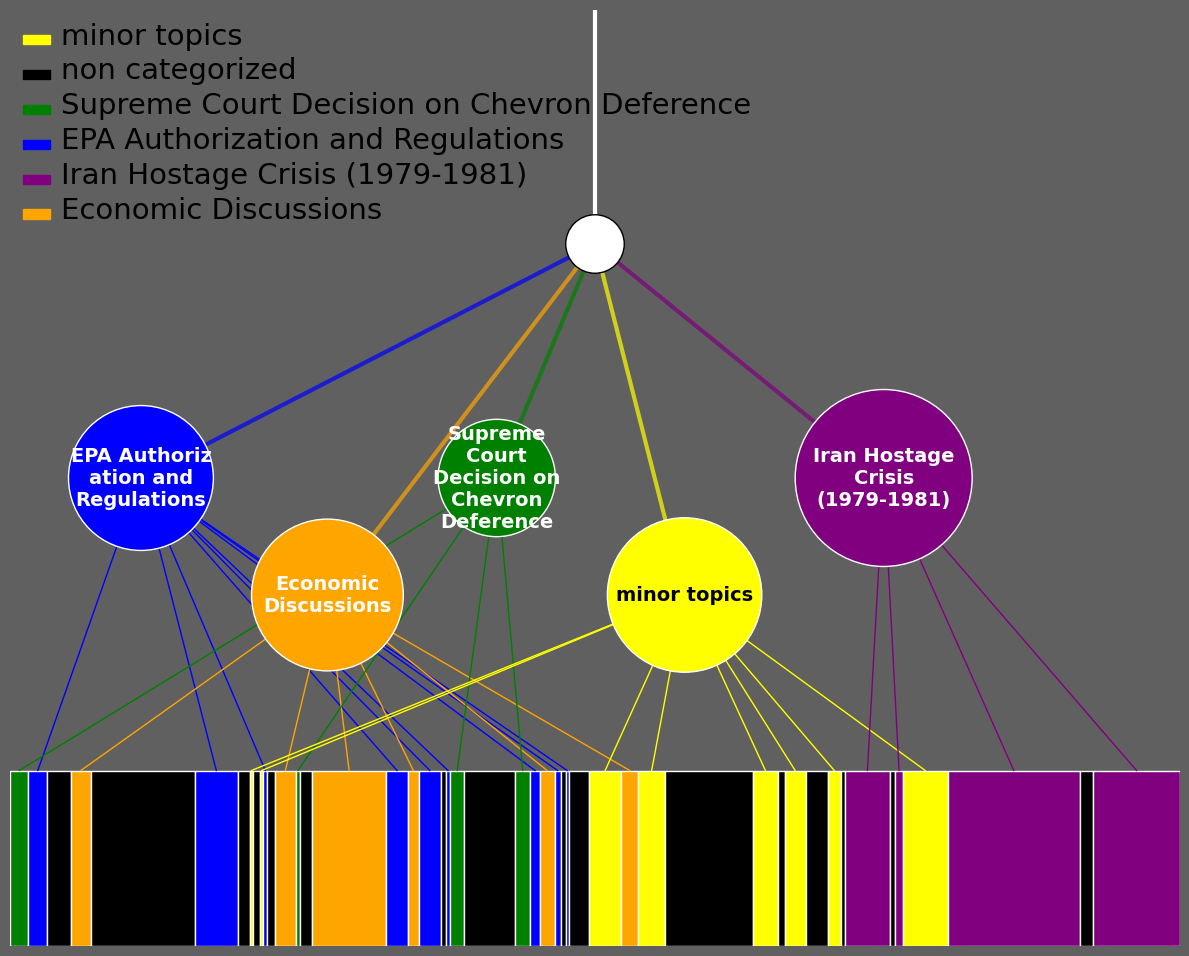

In [227]:
# Create the plot with a specific gray background
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#606060')  # Set figure background to [96, 96, 96]
ax.set_facecolor('#606060')  # Set axes background to [96, 96, 96]
target_plot_width=10


# Plot BAR 
current_x = 0
category_info = defaultdict(lambda: {"total_width": 0, "segments": []})

bar_height = 1.5


clickable_area_x_offset=0.085
clickable_area_y_offset=0.1
clickable_y_height_multiplier=1.2
clickable_areas=[]
href_base="https://youtu.be/"+video_id+"?t="


for i, segment in enumerate(segments):
    ax.add_patch(plt.Rectangle((current_x, 0), segment['width'], bar_height, 
                               facecolor=segment['color'], edgecolor='white'))
    category_info[segment['category']]['total_width'] += segment['width']
    category_info[segment['category']]['segments'].append((current_x, segment['width']))
    category_info[segment['category']]['color'] = segment['color']
    
    # Add clickable areas
    # this but a float and not a string f"{int((current_x+clickable_area_x_offset)*10)},{int((10-bar_height-clickable_area_y_offset)*10)},{int((current_x+segment['width']-clickable_area_x_offset)*10)},{int(10*(10-clickable_area_y_offset))}"}

    coord_list=[(current_x)*10, (10-(bar_height*clickable_y_height_multiplier)-clickable_area_y_offset)*10, (current_x+segment['width'])*10, 10*(10-clickable_area_y_offset)]

    # clickable_area={"alt":href, "title":href, "href":href, "coords": f"{int((current_x+clickable_area_x_offset)*10)},{int((10-bar_height-clickable_area_y_offset)*10)},{int((current_x+segment['width']-clickable_area_x_offset)*10)},{int(10*(10-clickable_area_y_offset))}"}
    href=href_base+str(int(segment["start"]))

    clickable_area={"alt":href, "title":href, "href":href, "coords": coord_list}

    clickable_areas.append(clickable_area)

    current_x += segment['width']

total_width = current_x
print("Total width:", total_width)







# sort category items by the same order as the category_locations
category_info=dict(sorted(category_info.items(), key=lambda item: category_locations[item[0]]))


# Calculate Circle Padding
circle_zone_size=9
circle_y = 3.5
circle_size_variable = 0.15

current_x=(target_plot_width-circle_zone_size)/2
circle_x_locations={}
total_circles_width=0
def get_circle_width(total_width):
    return (((np.sqrt(total_width) * circle_size_variable)*2)+0.3)

for category, info in category_info.items():
    if category == 'non categorized':
        pass
    else:
        circle_width=get_circle_width(info['total_width'])
        circle_x_locations[category]=circle_width
        total_circles_width+=circle_width
number_of_circles=len(circle_x_locations)
between_circle_padding=(circle_zone_size-total_circles_width)/(number_of_circles+1.15)



alterating_bool=False
vertical_offset=0
circle_centers = []
for category, info in category_info.items():
    if category == 'non categorized':
        continue

    circle_applied_size=get_circle_width(info['total_width'])

    # Calculate x position for the circle (center of all segments of this category)
    circle_x = current_x + circle_applied_size
    if alterating_bool:
        alterating_bool=False
        vertical_offset=-0.5
    else:
        vertical_offset=0.5
        alterating_bool=True

    # Store circle center, color, and size for later use
    circle_size = np.sqrt(info['total_width']) * circle_size_variable
    circle_applied_y=circle_y+vertical_offset
    circle_centers.append((circle_x, circle_applied_y, info['color'], circle_size))
    
    # DRAW LINES
    for segment_start, segment_width in info['segments']:
        segment_center = segment_start + segment_width / 2
        ax.plot([segment_center, circle_x], [bar_height, circle_applied_y], 
                color=info['color'], linewidth=1)  
        
    # PLOT CIRCLES
    circle = plt.Circle((circle_x, circle_applied_y), circle_applied_size, 
                        facecolor=info["color"], edgecolor='white', zorder=10)
    ax.add_artist(circle)

    # PLOT CIRCLE LABELS, set width to circle size and wrap
    text_wrap=textwrap.fill(category, width=12)
    bubble_font_size_text=14
    if info["color"]=="yellow":
        # make it bold and have a white border
        ax.text(circle_x, circle_applied_y, text_wrap, ha='center', va='center', color='black', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')#, bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2'))
    else:
        ax.text(circle_x, circle_applied_y, text_wrap, ha='center', va='center', color='white', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')

    # current_x += (info['total_width']*circle_mutlipler)+0.1
    current_x +=between_circle_padding+circle_applied_size
    print("Circle current x:", current_x)



# Add central white circle
central_y = 6
central_circle = plt.Circle((total_width/2, central_y), 0.25, 
                            facecolor='white', edgecolor='black', zorder=12)
ax.add_artist(central_circle)

# Connect category circles to central circle with colored lines
for circle_x, circle_y, color, circle_size in circle_centers:
    ax.plot([circle_x, total_width/2], [circle_y, central_y], 
            color=color, linewidth=3, linestyle='-', alpha=0.7, zorder=9)  # Increased linewidth

# Add white line extending upward from central circle
top_y = 100  # Adjust this value to change the length of the line
ax.plot([total_width/2, total_width/2], [central_y, top_y], 
        color='white', linewidth=3, solid_capstyle='round')  # Added white line

# Customize the plot
ax.set_xlim(0, total_width)
ax.set_ylim(0, 8)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

# Add a Legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_dict.values()]
legend_labels = list(color_dict.keys())
ax.legend(legend_handles, legend_labels, loc='upper left', frameon=False)
# increase legend font size
plt.setp(ax.get_legend().get_texts(), fontsize='21')



plt.tight_layout()
plt.savefig('segment_central_hub_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [211]:
# convert image to be smaller
from PIL import Image

img = Image.open('segment_central_hub_chart.png')
# get size of 
width, height = img.size
print(width, height)

# make it smaller until both width is less than 1920 and height is less than 1080
while width>1920 or height>1080:
    width=width/1.1
    height=height/1.1
width=int(width)
height=int(height)
print(width, height)

# resize the image
img = img.resize((width, height), Image.LANCZOS)

img.save('segment_central_hub_chart.png', dpi=(300, 300))


3570 2868
1251 1005


In [212]:
# save the image to the database
# import base64

import base64

# convert image to base64 string
image_path="segment_central_hub_chart_transparent.png"
with open(image_path, "rb") as img_file:
    b64_string = base64.b64encode(img_file.read()).decode()

print(len(b64_string))

1089024


In [221]:
from PIL import Image

# Open the image file
img = Image.open('segment_central_hub_chart.png')

# Make the background transparent
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    # if pixel is value [96, 96, 96] then set pixel to transparent
    if item[0] == 96 and item[1] == 96 and item[2] == 96:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)

# Update image data
img.putdata(newData)

# Save the new image
img.save("segment_central_hub_chart_transparent.png", "PNG")

In [28]:
from IPython.display import display, HTML

In [228]:
# open image from image_path
from PIL import Image

img = Image.open(image_path)

# get the dimensions of the image
width, height = img.size
print(width, height)



converted_clickable_areas=[]

coords_x_offset=0.84
coords_x_adjustment=0.9833
coords_y_adjustment=1.0
for i, clickable_area in enumerate(clickable_areas):
    # coords_str=clickable_area["coords"]
    # coords=coords_str.split(",")
    # coords=[int(coord) for coord in coords]
    # convert to pixels where 100 is 100% of the image
    # href="test"+str(i)
    coords=clickable_area["coords"]
    href=clickable_area["href"]
    coords=[int((((coord*coords_x_adjustment)+coords_x_offset)/100)*width) if i%2==0 else int((coord*coords_y_adjustment)/100*height) for i, coord in enumerate(coords)]
    converted_clickable_areas.append({"coords": coords, "href": href, "alt": href, "title": href})
    
    # converted_clickable_areas.append({"coords": coords, "href": clickable_area["href"], "alt": clickable_area["alt"], "title": clickable_area["title"]})
    print(coords)

3570 2868
[29, 2323, 85, 2839]
[85, 2323, 141, 2839]
[141, 2323, 212, 2839]
[212, 2323, 273, 2839]
[273, 2323, 583, 2839]
[583, 2323, 714, 2839]
[714, 2323, 748, 2839]
[748, 2323, 759, 2839]
[759, 2323, 780, 2839]
[780, 2323, 789, 2839]
[789, 2323, 802, 2839]
[802, 2323, 825, 2839]
[825, 2323, 886, 2839]
[886, 2323, 901, 2839]
[901, 2323, 935, 2839]
[935, 2323, 1158, 2839]
[1158, 2323, 1223, 2839]
[1223, 2323, 1256, 2839]
[1256, 2323, 1322, 2839]
[1322, 2323, 1338, 2839]
[1338, 2323, 1350, 2839]
[1350, 2323, 1393, 2839]
[1393, 2323, 1545, 2839]
[1545, 2323, 1591, 2839]
[1591, 2323, 1619, 2839]
[1619, 2323, 1664, 2839]
[1664, 2323, 1681, 2839]
[1681, 2323, 1697, 2839]
[1697, 2323, 1706, 2839]
[1706, 2323, 1767, 2839]
[1767, 2323, 1863, 2839]
[1863, 2323, 1915, 2839]
[1915, 2323, 1995, 2839]
[1995, 2323, 2260, 2839]
[2260, 2323, 2332, 2839]
[2332, 2323, 2353, 2839]
[2353, 2323, 2417, 2839]
[2417, 2323, 2484, 2839]
[2484, 2323, 2521, 2839]
[2521, 2323, 2535, 2839]
[2535, 2323, 2669, 2839]

In [229]:
def generate_html(image_path, clickable_areas):
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Interactive Image Map</title>
        <style>
            #image-container {{
                position: relative;
                display: inline-block;
            }}
            .clickable-area {{
                position: absolute;
                cursor: pointer;
                border: 2px solid rgba(255, 0, 0, 0.5);
                box-sizing: border-box;
            }}
        </style>
    </head>
    <body>
        <div id="image-container">
            <img src="{image_path}" alt="Your Image Description" id="main-image">
        </div>

        <script>
            const imageContainer = document.getElementById('image-container');
            const mainImage = document.getElementById('main-image');

            mainImage.onload = function() {{
                const areas = [
    """
    
    for area in clickable_areas:
        html_content += f"                    {{alt: \"{area['alt']}\", title: \"{area['title']}\", href: \"{area['href']}\", coords: [{','.join(map(str, area['coords']))}]}},\n"
    
    html_content += """
                ];

                areas.forEach(area => {
                    const div = document.createElement('div');
                    div.className = 'clickable-area';
                    div.style.left = `${area.coords[0]}px`;
                    div.style.top = `${area.coords[1]}px`;
                    div.style.width = `${area.coords[2] - area.coords[0]}px`;
                    div.style.height = `${area.coords[3] - area.coords[1]}px`;
                    div.title = area.title;
                    div.onclick = function() { window.open(area.href, '_blank'); };
                    imageContainer.appendChild(div);
                });
            };
        </script>
    </body>
    </html>
    """
    
    return html_content

def generate_html(image_path, clickable_areas):
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Interactive Image Map with Effects</title>
        <style>
            #image-container {{
                position: relative;
                display: inline-block;
            }}
            .clickable-area {{
                position: absolute;
                cursor: pointer;
                box-sizing: border-box;
                transition: all 0.3s ease;
            }}
            .clickable-area:hover {{
                background-color: rgba(255, 255, 255, 0.8);
                border: 2px solid rgba(255, 0, 0, 0.8);
            }}
        </style>
    </head>
    <body>
        <div id="image-container">
            <img src="{image_path}" alt="Your Image Description" id="main-image">
        </div>

        <script>
            const imageContainer = document.getElementById('image-container');
            const mainImage = document.getElementById('main-image');

            mainImage.onload = function() {{
                const areas = [
    """
    
    for area in clickable_areas:
        html_content += f"                    {{alt: \"{area['alt']}\", title: \"{area['title']}\", href: \"{area['href']}\", coords: [{','.join(map(str, area['coords']))}]}},\n"
    
    html_content += """
                ];

                areas.forEach(area => {
                    const div = document.createElement('div');
                    div.className = 'clickable-area';
                    div.style.left = `${area.coords[0]}px`;
                    div.style.top = `${area.coords[1]}px`;
                    div.style.width = `${area.coords[2] - area.coords[0]}px`;
                    div.style.height = `${area.coords[3] - area.coords[1]}px`;
                    div.title = area.title;
                    div.onclick = function(e) {
                        e.preventDefault();
                        this.classList.toggle('clicked');
                        setTimeout(() => {
                            window.open(area.href, '_blank');
                        }, 300);
                    };
                    imageContainer.appendChild(div);
                });
            };
        </script>
    </body>
    </html>
    """
    
    return html_content

# # Example usage
# clickable_areas = [
#     {"alt": "EPA Authorization", "title": "EPA Authorization", "href": "https://example.com/epa", "coords": [50, 100, 150, 200]},
#     # Add more areas as needed
# ]

html_output = generate_html(image_path, converted_clickable_areas)

# Save the HTML to a file
with open("interactive_plot.html", "w") as f:
    f.write(html_output)

# Extra results prcessing

In [25]:
annotations_segemnts_str=""

for i, annoation_result in enumerate(annotated_results):
    annotations_segemnts_str+="Segment: "+str(i)+": "+annoation_result["annotation"]+"\n"
len(annotations_segemnts_str)

35534

In [ ]:
Major Topics:

Category: 'Chevron Deference Doctrine' | Context: Discussion of the Supreme Court's recent decision overturning the Chevron deference doctrine, its implications for administrative law, and the debate surrounding judicial deference to administrative agencies.

Category: 'Gun Control and Regulations' | Context: Detailed examination of bump stocks, their functionality, legal classification, and the broader debate on gun control laws, including Destiny's views on machine gun regulations.

Category: 'American Identity and Political Division' | Context: Reflection on core American values, current political divisions particularly regarding Trump supporters, and concerns about some conservatives departing from traditional American values.

Category: 'Legal and Constitutional Issues' | Context: Analysis of Supreme Court decisions, discussions on stare decisis, the role of courts versus agency expertise in interpreting laws, and examination of separation of powers.

Minor Topics:
- 'Destiny's personal experiences with firearms'
- 'Specific Supreme Court cases (e.g., Ohio v. EPA)'
- 'January 6th events and its classification as an insurrection'
- 'Historical events like Vietnam War and Civil Rights movement'
- 'Federalist Society's role in pushing for deregulation'
- 'Qualified immunity'
- 'Writing styles of Supreme Court justices'
- 'UN resolutions and Israel-Palestine conflicts'
- 'Potential review of "Project 2025" from the Trump campaign'
- 'Length and definition of a Supreme Court term'
- 'Legal concepts like "arbitrary and capricious" standard'
- 'Section 3 of the 14th Amendment case related to Trump's eligibility'
- 'Past arguments with Nick Fuentes about ethnic character of the US'

In [26]:
system_prompt="""Take the annotated segments from the user and break down the segments into a few major topics and minor topics. Format the response as follows:

Main Topics:
Category: 'Category' | Context: context
...

Minor topics:
- 'minor topic'
...

"""

user_prompt="Here are all the annotationed segments:\n"+annotations_segemnts_str

prompt=[{"role":"system", "content":system_prompt}, {"role":"user", "content":user_prompt}]

In [27]:
topic_annotations_str2, cost=await utils.async_response_handler(
    prompt,
    utils.ModelNameEnum.claude_3_5_sonnet
)

In [28]:
print(topic_annotations_str2)

Main Topics:
Category: Travel | Context: Personal experiences and reflections on travel after raising children
Category: Family and Society | Context: Importance of family ties and multi-generational living
Category: Wealth and Power | Context: Interactions with wealthy individuals and their mindsets
Category: Jeffrey Epstein Case | Context: Personal encounter and speculations about Epstein's background
Category: Unidentified Aerial Phenomena (UAPs) | Context: Recent developments and theories surrounding UAPs
Category: Institutional Trust | Context: Erosion of trust in institutions and challenges in discerning truth
Category: Physics and Space Exploration | Context: Limitations of current physics theories and the need for breakthroughs
Category: Technology and Human Experience | Context: Impact of technology on human connections and experiences
Category: MMA and Cultural Differences | Context: Analysis of McGregor-Nurmagomedov rivalry
Category: Free Speech and Information | Context: Ch